In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow as tf
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from tensorflow.keras.utils import *
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils
from numpy import argmax
import seaborn as sn 

from random import seed
from random import randint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
#X = np.load('../InpactorDB/version_final/InpactorDB_non-redudant.fasta.filtered_zeros.npy').astype(np.int8)
#Y = np.load('../InpactorDB/version_final/InpactorDB_non-redudant.fasta.filtered_zeros_labels.npy').astype(np.int8)

X = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/InpactorDB_non-redundant_final_format_position.npy').astype(bool)
Y = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/InpactorDB_non-redundant_final_format_position_labels.npy').astype(np.int32)

In [5]:
# extract 70k sequences randomly
already = []
X_new = np.zeros((100000, X.shape[1], X.shape[2]), dtype=np.int8)
Y_new = np.zeros((100000, Y.shape[1]), dtype=np.float64)
i = 0
seed(1)
while i < 100000:
    value = randint(0, X.shape[0]-1)
    if value not in already:
        X_new[i] = X[value, :, :]
        Y_new[i, 0] = Y[value, 0]
        Y_new[i, 1] = Y[value, 1]
        i += 1
        already.append(value)
        
X = X_new
Y = Y_new[:, 0]
Y[Y > 0] = 1

In [6]:
print(X.shape)
print(Y.shape)

type(X[0, 0, 0])
print(Y)

(100000, 5, 50000)
(100000,)
[1. 0. 1. ... 1. 1. 0.]


In [7]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

(80000, 5, 50000)
(80000,)
(10000, 5, 50000)
(10000,)
(10000, 5, 50000)
(10000,)


In [8]:
X = None
Y = None
path_log_base = './logs_CNN'

In [9]:
def metrics(Y_validation,predictions):
    
    classes = len(numpy.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [10]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Acuraccy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation accuracy {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [11]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'LeakyReLU': tensorflow.keras.layers.LeakyReLU(alpha=0.1)})
            loss,accuracy = model.evaluate(X_test, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [12]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [13]:
def Experiments():
    tf.keras.backend.clear_session()

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(32, (5, 20), strides=(1,1), activation="relu", use_bias=True)(inputs)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 10), strides= (1, 10))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 2
    layers = tf.keras.layers.Conv2D(64, (1, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 15), strides= (1, 15))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 3
    layers = tf.keras.layers.Conv2D(128, (1, 35), strides=(1,1), activation="relu", use_bias=True)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 15), strides= (1, 15))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    #layers = tf.keras.layers.Dense(1200,activation="relu")(layers)
    layers = tf.keras.layers.Dense(1000,activation="relu")(layers)
    layers = tf.keras.layers.Dense(500,activation="relu")(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(1, activation="sigmoid", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95)
    opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    #opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    # Compile model
    #model.compile(loss=[avg_euclidean_distance], optimizer=opt, metrics=[avg_center_point_diff])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model

In [14]:
def INPACTORdet_net():
    """
    Best result test:
    
    Accuracy: 0.9741
    F1 score: 0.9741001592876776
    Recall: 0.9741
    Precision: 0.9741047020517859
    
    logs_CNN/TERL_2021-04-29_11-46-52/saved-model-083-0.9765.hdf5

    """
    tf.keras.backend.clear_session()

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(32, (5, 20), strides=(1,1), activation="relu", use_bias=True)(inputs)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 10), strides= (1, 10))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 2
    layers = tf.keras.layers.Conv2D(64, (1, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 15), strides= (1, 15))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 3
    layers = tf.keras.layers.Conv2D(128, (1, 35), strides=(1,1), activation="relu", use_bias=True)(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 15), strides= (1, 15))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    #layers = tf.keras.layers.Dense(1200,activation="relu")(layers)
    layers = tf.keras.layers.Dense(1000,activation="relu")(layers)
    layers = tf.keras.layers.Dense(500,activation="relu")(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(1, activation="sigmoid", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95)
    opt = tf.keras.optimizers.SGD(learning_rate=0.01)
    # loss function
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    # Compile model
    #model.compile(loss=[avg_euclidean_distance], optimizer=opt, metrics=[avg_center_point_diff])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 50000, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 49981, 32)      3232      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 4998, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 4979, 64)       41024     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 331, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 297, 128)       286848    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 19, 128)        0     

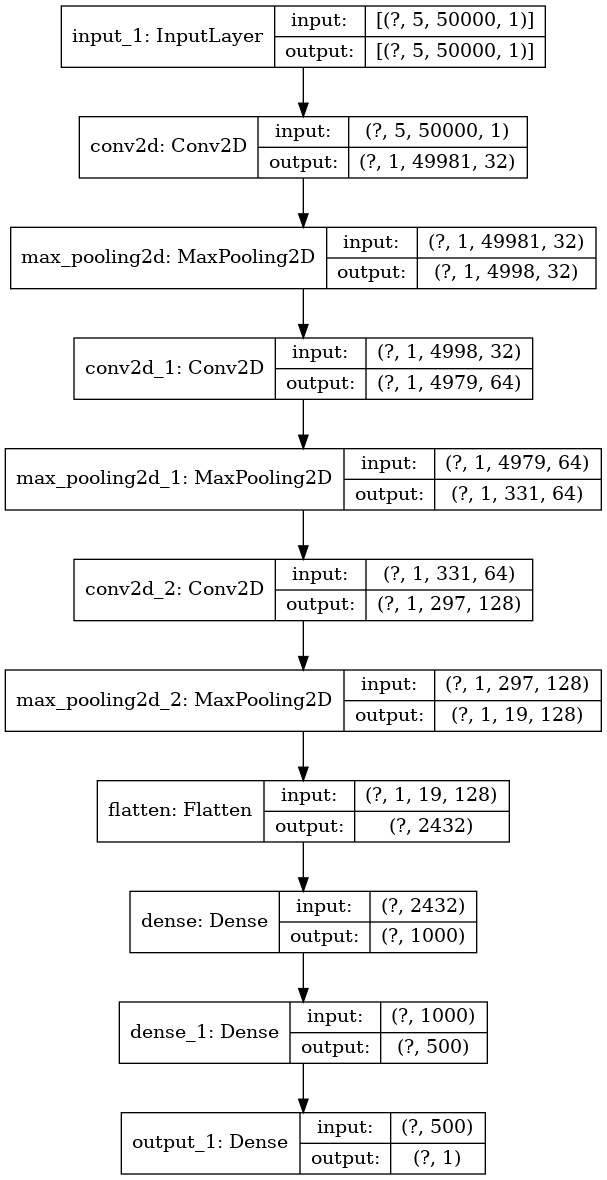

In [15]:
model = INPACTORdet_net()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
one_hot_labels_train = Y_train#tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = Y_dev#tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = Y_test#tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, 64, epochs, "TERL")
Final_Results_Test(log_Dir) 

Epoch 1/100
1250/1250 [==============================] - 54s 43ms/step - loss: 0.6933 - accuracy: 0.5018 - val_loss: 0.6929 - val_accuracy: 0.5053
Epoch 2/100
1250/1250 [==============================] - 54s 43ms/step - loss: 0.6930 - accuracy: 0.5077 - val_loss: 0.6926 - val_accuracy: 0.5105
Epoch 3/100
1250/1250 [==============================] - 54s 43ms/step - loss: 0.6924 - accuracy: 0.5153 - val_loss: 0.6913 - val_accuracy: 0.5455
Epoch 4/100
1250/1250 [==============================] - 54s 43ms/step - loss: 0.6890 - accuracy: 0.5386 - val_loss: 0.6800 - val_accuracy: 0.6126
Epoch 5/100
1250/1250 [==============================] - 55s 44ms/step - loss: 0.6682 - accuracy: 0.5795 - val_loss: 0.6567 - val_accuracy: 0.6291
Epoch 6/100
1250/1250 [==============================] - 60s 48ms/step - loss: 0.6071 - accuracy: 0.6572 - val_loss: 0.5417 - val_accuracy: 0.7219
Epoch 7/100
1250/1250 [==============================] - 60s 48ms/step - loss: 0.5470 - accuracy: 0.7118 - val_loss: 0

1250/1250 [==============================] - 55s 44ms/step - loss: 3.0362e-04 - accuracy: 1.0000 - val_loss: 0.1056 - val_accuracy: 0.9755
Epoch 57/100
1250/1250 [==============================] - 54s 43ms/step - loss: 2.6572e-04 - accuracy: 1.0000 - val_loss: 0.1059 - val_accuracy: 0.9766
Epoch 58/100
1250/1250 [==============================] - 54s 43ms/step - loss: 2.3868e-04 - accuracy: 1.0000 - val_loss: 0.1077 - val_accuracy: 0.9755
Epoch 59/100
1250/1250 [==============================] - 54s 43ms/step - loss: 2.1491e-04 - accuracy: 1.0000 - val_loss: 0.1083 - val_accuracy: 0.9759
Epoch 60/100
1250/1250 [==============================] - 55s 44ms/step - loss: 1.9682e-04 - accuracy: 1.0000 - val_loss: 0.1093 - val_accuracy: 0.9757
Epoch 61/100
1250/1250 [==============================] - 54s 44ms/step - loss: 1.8049e-04 - accuracy: 1.0000 - val_loss: 0.1088 - val_accuracy: 0.9764
Epoch 62/100
1250/1250 [==============================] - 54s 43ms/step - loss: 1.6751e-04 - accuracy

Loss=0.1379 y F1-Score=0.9502

saved-model-024-0.9501.hdf5
Loss=0.1484 y F1-Score=0.9465

saved-model-025-0.9547.hdf5
Loss=0.1290 y F1-Score=0.9536

saved-model-026-0.9666.hdf5
Loss=0.1090 y F1-Score=0.9620

saved-model-027-0.9638.hdf5
Loss=0.1102 y F1-Score=0.9607

saved-model-028-0.9614.hdf5
Loss=0.1191 y F1-Score=0.9587

saved-model-029-0.9719.hdf5
Loss=0.0991 y F1-Score=0.9676

saved-model-030-0.9689.hdf5
Loss=0.1050 y F1-Score=0.9679

saved-model-031-0.9681.hdf5
Loss=0.1088 y F1-Score=0.9653

saved-model-032-0.9727.hdf5
Loss=0.1032 y F1-Score=0.9673

saved-model-033-0.7132.hdf5
Loss=0.5268 y F1-Score=0.7090

saved-model-034-0.9681.hdf5
Loss=0.1146 y F1-Score=0.9656

saved-model-035-0.9711.hdf5
Loss=0.1054 y F1-Score=0.9683

saved-model-036-0.9726.hdf5
Loss=0.1164 y F1-Score=0.9675

saved-model-037-0.9739.hdf5
Loss=0.1200 y F1-Score=0.9690

saved-model-038-0.9758.hdf5
Loss=0.1204 y F1-Score=0.9693

saved-model-039-0.9735.hdf5
Loss=0.1238 y F1-Score=0.9693

saved-model-040-0.9739.hd

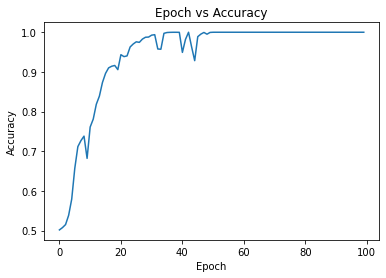

Test F1-Score 0.9728999733924866, Época:71

Test F1-Score 0.9726999998092651, Época:85

Test F1-Score 0.972599983215332, Época:74

Test F1-Score 0.972599983215332, Época:76

Test F1-Score 0.9724000096321106, Época:69


Train Acuraccy 1.0, Época:52

Train Acuraccy 1.0, Época:53

Train Acuraccy 1.0, Época:54

Train Acuraccy 1.0, Época:55

Train Acuraccy 1.0, Época:56


Validation accuracy 0.9772999882698059, Época:79

Validation accuracy 0.9772999882698059, Época:88

Validation accuracy 0.9771999716758728, Época:78

Validation accuracy 0.9771999716758728, Época:81

Validation accuracy 0.9771999716758728, Época:95



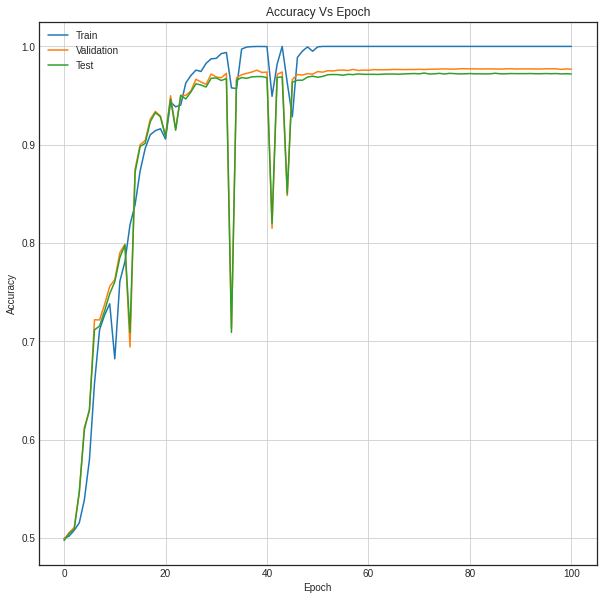

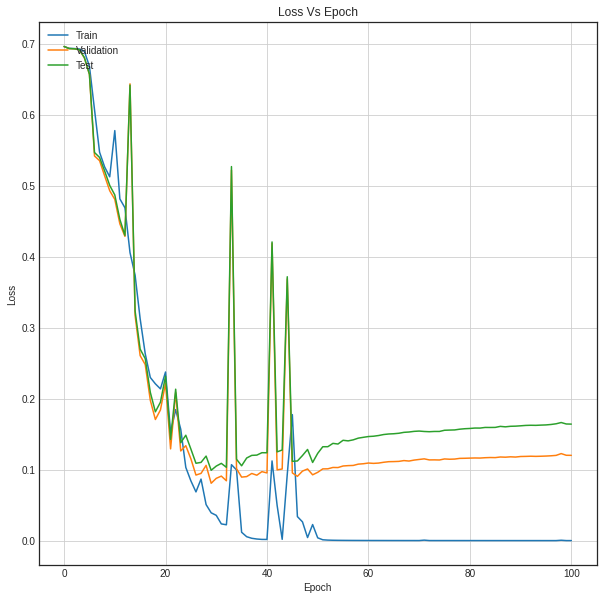

In [18]:
# plot metrics
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


Baseline Error train: 0.0
Baseline Error dev: 2.3500025272369385
Baseline Error test: 2.7100026607513428
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]]
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     39954
         1.0       1.00      1.00      1.00     40046

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


 confusion matrix:
 [[39954     0]
 [    0 40046]]


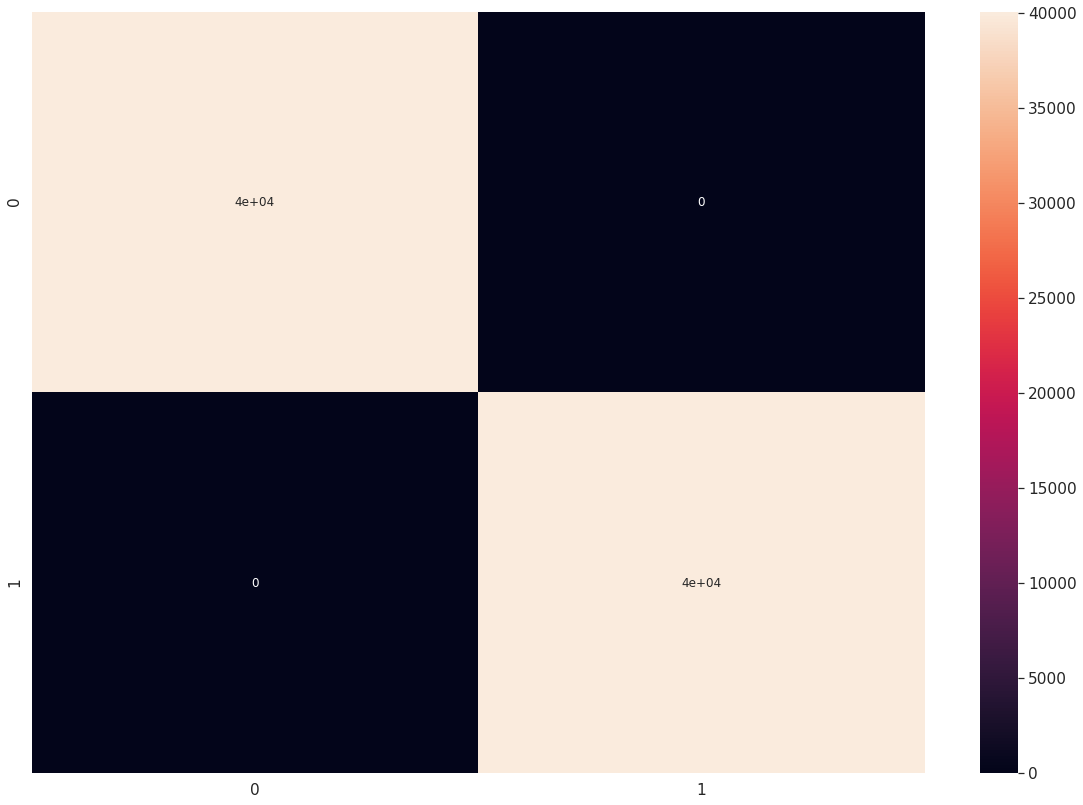

Accuracy: 0.9765
F1 score: 0.9764999358449684
Recall: 0.9765
Precision: 0.9765295774458588

 clasification report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      4984
         1.0       0.98      0.97      0.98      5016

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


 confusion matrix:
 [[4886   98]
 [ 137 4879]]


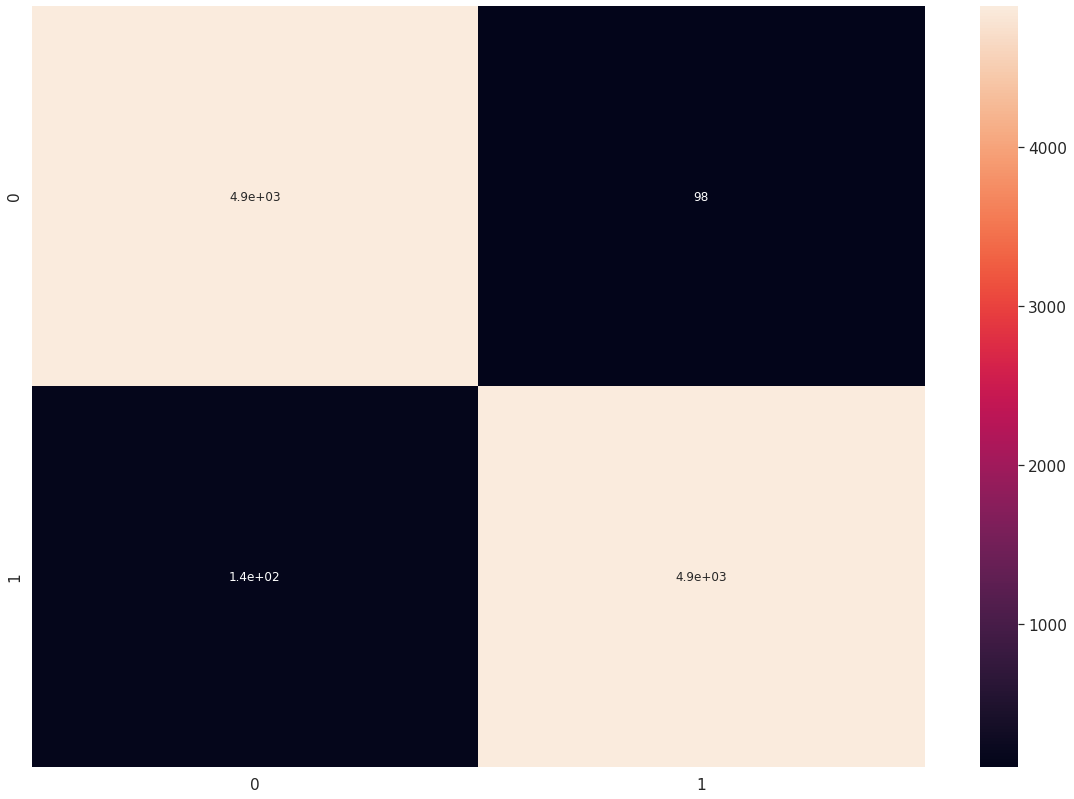

Accuracy: 0.9729
F1 score: 0.9729002100270183
Recall: 0.9729
Precision: 0.9729125813045293

 clasification report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      4972
         1.0       0.98      0.97      0.97      5028

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 confusion matrix:
 [[4849  123]
 [ 148 4880]]


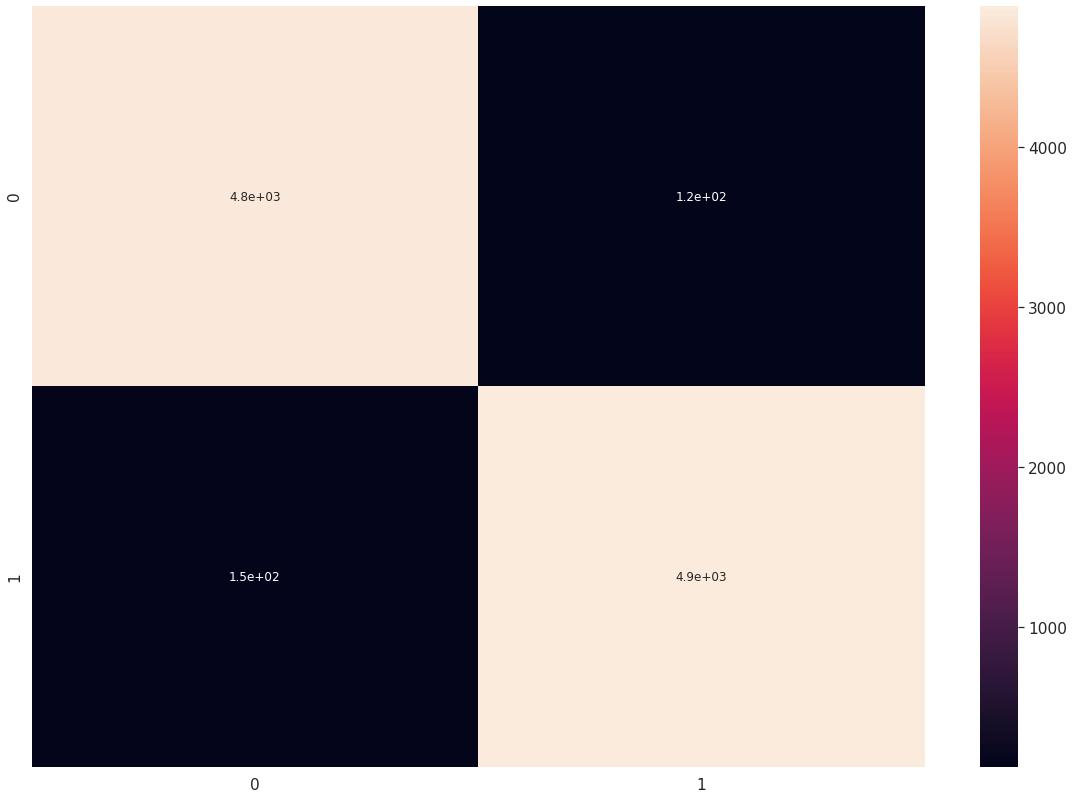

In [19]:
model = tf.keras.models.load_model(log_Dir+'/saved-model-071-0.9765.hdf5', custom_objects={'LeakyReLU': tensorflow.keras.layers.LeakyReLU(alpha=0.1)})
scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: " +str((1 - scores[1])*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: " +str((1 - scores[1])*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: " +str((1 - scores[1])*100))

predictions = np.array(model.predict(X_train))
predictions[predictions >= 0.5] = 1 
predictions[predictions < 0.5] = 0

print(predictions)

metrics(Y_train, predictions)

predictions = np.array(model.predict(X_dev))
predictions[predictions >= 0.5] = 1 
predictions[predictions < 0.5] = 0

metrics(Y_dev, predictions)

predictions = np.array(model.predict(X_test))
predictions[predictions >= 0.5] = 1 
predictions[predictions < 0.5] = 0

metrics(Y_test, predictions)


0.9615032588720435


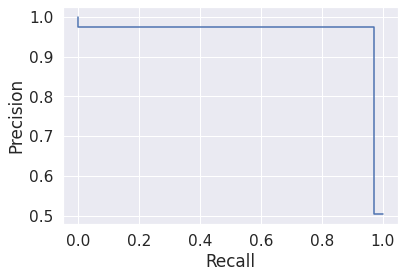

In [21]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(Y_test, predictions)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
#plt.savefig(bbox_inches='tight',dpi=500)

print(average_precision_score(Y_test, predictions))

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(Y_test, predictions)
auc = roc_auc_score(Y_test, predictions)
print('AUC: %.3f' % auc)

AUC: 0.973
